# Workshop 8. Наивный Байес и Классификация текстов

> Байесовские алгоритмы для классификации текстов  
> Извлечение признаков из текста

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [205]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [206]:
categories = ['alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics']

# Загрузка тренировочной и тестовой части датасета
train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

Выведите по 1 тексту для каждой из категории.

In [207]:
for category in categories:
    index = next((i for i, t in enumerate(train_data.target) if train_data.target_names[t] == category), None)
    if index is not None:
        print(f"Category: {category}\n")
        print(train_data.data[index])
        print('\n')

Category: alt.atheism

From: dpw@sei.cmu.edu (David Wood)
Subject: Request for Support
Organization: Software Engineering Institute
Lines: 35



I have a request for those who would like to see Charley Wingate
respond to the "Charley Challenges" (and judging from my e-mail, there
appear to be quite a few of you.)  

It is clear that Mr. Wingate intends to continue to post tangential or
unrelated articles while ingoring the Challenges themselves.  Between
the last two re-postings of the Challenges, I noted perhaps a dozen or
more posts by Mr. Wingate, none of which answered a single Challenge.  

It seems unmistakable to me that Mr. Wingate hopes that the questions
will just go away, and he is doing his level best to change the
subject.  Given that this seems a rather common net.theist tactic, I
would like to suggest that we impress upon him our desire for answers,
in the following manner:

1. Ignore any future articles by Mr. Wingate that do not address the
Challenges, until he answers

### 2.2 Мешок слов

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [208]:
from sklearn.feature_extraction.text import CountVectorizer

# Создание объекта CountVectorizer с английскими стоп-словами
vectorizer = CountVectorizer(stop_words='english')

# Трансформация текстов из обоих датасетов
vectorizer.fit_transform(train_data.data)
vectorizer.transform(test_data.data)

# Вывод размера словаря
print(f"Размер словаря: { len(vectorizer.get_feature_names_out())}")

Размер словаря: 33814


Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [209]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test =  train_data.data, test_data.data, train_data.target, test_data.target

# Преобразуем текстовые данные в векторы признаков
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)

# Инициализируем классификатор и проводим 5-кратную кросс-валидацию
clf = MultinomialNB()
scores = cross_val_score(clf, X_train_vectorized, y_train, cv=5, scoring='accuracy')

# Выводим среднюю точность классификатора на кросс-валидации
print('Accuracy:', np.mean(scores))


Accuracy: 0.9552583483617966


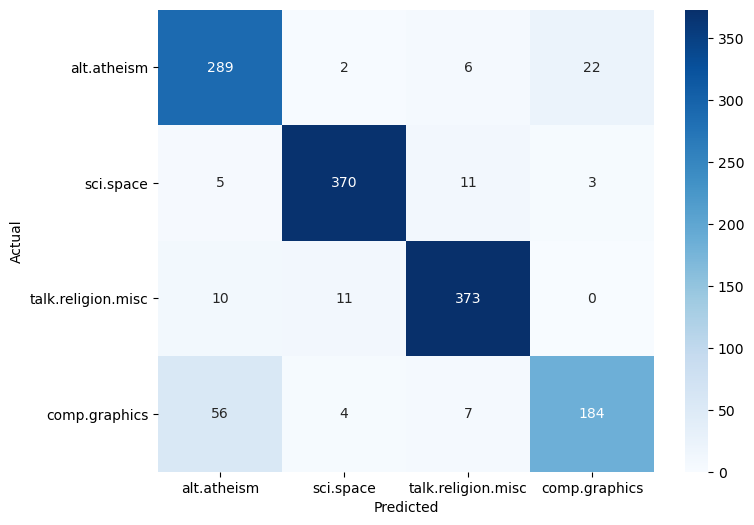

In [210]:
import seaborn as sns

# Обучаем классификатор на тренировочных данных
clf.fit(X_train_vectorized, y_train)

# Преобразуем тестовые данные в векторы признаков
X_test_vectorized = vectorizer.transform(X_test)

# Получаем прогнозы для тестовой выборки
y_pred = clf.predict(X_test_vectorized)

# Создаем матрицу ошибок
cm = confusion_matrix(y_test, y_pred)

# Отображаем матрицу ошибок
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [211]:
# Выводим отчет классификации
print(classification_report(y_test, y_pred, target_names=train_data.target_names))

                    precision    recall  f1-score   support

       alt.atheism       0.80      0.91      0.85       319
     comp.graphics       0.96      0.95      0.95       389
         sci.space       0.94      0.95      0.94       394
talk.religion.misc       0.88      0.73      0.80       251

          accuracy                           0.90      1353
         macro avg       0.89      0.88      0.89      1353
      weighted avg       0.90      0.90      0.90      1353



In [212]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.feature_log_prob_[i])[-10:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

show_top10(clf, vectorizer, train_data.target_names)

alt.atheism: [not you it in and that is to of the]
comp.graphics: [you from it for in is and of to the]
sci.space: [space it for that is in and to of the]
talk.religion.misc: [not it you is in that and to of the]


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF)

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [230]:
from sklearn.metrics import accuracy_score

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)


clf = MultinomialNB()
cv_scores = cross_val_score(clf, X_train_vectorized, y_train, cv=5, scoring='accuracy')

clf.fit(X_train_vectorized, y_train)

test_preds = clf.predict(X_train_vectorized)

test_accuracy = accuracy_score(y_train, test_preds)
print(f"Точность на тестовых данных: {test_accuracy:.3f}")

Точность на тестовых данных: 0.987


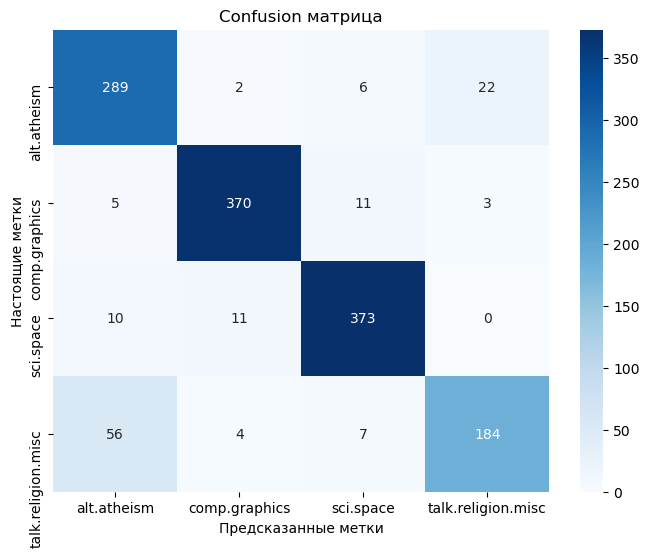

In [226]:
cm = confusion_matrix(test_data.target, test_preds)
class_names = test_data.target_names
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_title("Confusion матрица")
ax.set_xlabel("Предсказанные метки")
ax.set_ylabel("Настоящие метки")
plt.show()

In [227]:
print("Отчет классификации:")
print(classification_report(test_data.target, test_preds, target_names=class_names))

Отчет классификации:
                    precision    recall  f1-score   support

       alt.atheism       0.80      0.91      0.85       319
     comp.graphics       0.96      0.95      0.95       389
         sci.space       0.94      0.95      0.94       394
talk.religion.misc       0.88      0.73      0.80       251

          accuracy                           0.90      1353
         macro avg       0.89      0.88      0.89      1353
      weighted avg       0.90      0.90      0.90      1353



In [229]:
show_top10(clf, vectorizer, train_data.target_names)

alt.atheism: [not you it in and that is to of the]
comp.graphics: [you from it for in is and of to the]
sci.space: [space it for that is in and to of the]
talk.religion.misc: [not it you is in that and to of the]


### 2.4 В чём проблема?

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

Ответ: 

Некоторые тексты могут содержать слова, которые характерны для нескольких категорий одновременно, что делает их классификацию более сложной. Например, слово "space" может быть характерным для категории "sci.space", но также может встречаться в текстах из других категорий.

Во-вторых, в нашем наборе данных может быть несбалансированное количество текстов в каждой категории, что может привести к тому, что классификатор будет более склонен к определенным категориям и менее точен в других.

При анализе матрицы можно заметить, что наибольшее количество ошибок происходит между категориями "alt.atheism" и "talk.religion.misc". Это может быть связано с тем, что эти категории содержат тексты, связанные с религией и верой, и могут иметь схожие темы. Также можно заметить, что наиболее точно классифицируются тексты из категории "comp.graphics".

В отчете классификации можно увидеть precision, recall и f1-score для каждой категории. Precision показывает, как много из предсказанных текстов действительно относятся к данной категории, а recall показывает, как много текстов данной категории были правильно определены. F1-score является средним гармоническим между precision и recall и показывает общую точность классификации. Из отчета можно сделать вывод, что наиболее точно классифицируются тексты из категории "comp.graphics", а наименее точно - из категорий "alt.atheism" и "talk.religion.misc".

Таким образом, проблемы в точности классификации могут быть связаны с тематикой текстов, несбалансированным количеством текстов в каждой категории, а также с наличием слов, характерных для нескольких категорий одновременно. 

![](https://i.imgur.com/3D5pgrk.png)

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.